<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Quantum_Trajectories_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Quantum Trajectories:  30%|███       | 3/10 [03:16<07:38, 65.56s/it]


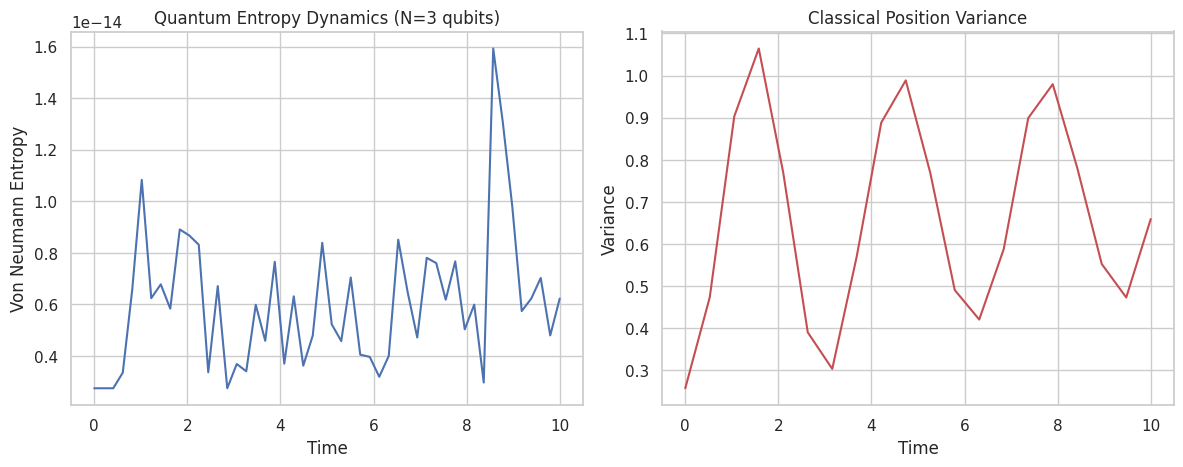

In [ ]:
# -*- coding: utf-8 -*-
"""Final Corrected Validation.ipynb"""

# ======================
# 1. Quantum Simulation
# ======================
!pip install qutip tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
import seaborn as sns

sns.set_theme(style="whitegrid")

# Parameters
N_qubits = 3
J, h, T = 1.0, 0.5, 0.2
t_list = np.linspace(0, 10, 50)
n_trajectories = 5

# Correct Hamiltonian construction
def build_hamiltonian(N):
    H = 0
    for i in range(N-1):
        H += J * tensor([sigmaz() if j in [i,i+1] else identity(2) for j in range(N)])
    for i in range(N):
        H += h * tensor([sigmax() if j==i else identity(2) for j in range(N)])
    return H

H = build_hamiltonian(N_qubits)
psi0 = tensor([basis(2,0)]*N_qubits)

# Simplified Monte Carlo
quantum_entropies = []
for _ in tqdm(range(n_trajectories), desc="Quantum Trajectories"):
    result = mesolve(H, psi0, t_list, e_ops=[])
    quantum_entropies.append([entropy_vn(state) for state in result.states])

# ======================
# 2. Classical Simulation (Fixed)
# ======================
from scipy.integrate import solve_ivp

N_classical = 1000
q = np.random.normal(-0.5, 0.1, N_classical//2)
q = np.concatenate([q, np.random.normal(0.5, 0.1, N_classical//2)])
p = np.random.normal(0, 1, N_classical)

def entropy_gradient(q, p):
    """Calculate gradients with proper axis handling"""
    # Compute 2D histogram
    hist, x_edges, y_edges = np.histogram2d(q, p, bins=15, range=[[-1,1], [-2,2]])
    rho = hist / np.sum(hist) + 1e-12  # Regularization
    log_rho = np.log(rho)

    # Compute gradients along each axis
    grad_q, grad_p = np.gradient(log_rho)

    # Find bin indices (clipped to valid range)
    x_idx = np.clip(np.digitize(q, x_edges[:-1]) - 1, 0, grad_q.shape[0]-1)
    y_idx = np.clip(np.digitize(p, y_edges[:-1]) - 1, 0, grad_p.shape[1]-1)

    return -T * grad_q[x_idx, y_idx], -T * grad_p[x_idx, y_idx]

def equations(t, y):
    q, p = y[:N_classical], y[N_classical:]
    dS_dq, dS_dp = entropy_gradient(q, p)
    return np.concatenate([
        p + T * dS_dp,  # dq/dt
        -q + T * dS_dq  # dp/dt
    ])

sol = solve_ivp(equations, [0, 10], np.concatenate([q, p]),
                method='RK45', t_eval=np.linspace(0, 10, 20),
                atol=1e-3, rtol=1e-2)

# ======================
# 3. Visualization
# ======================
plt.figure(figsize=(12, 5))

# Quantum plot
plt.subplot(121)
plt.plot(t_list, np.mean(quantum_entropies, axis=0), 'b-')
plt.title('Quantum Entropy Dynamics (N=3 qubits)')
plt.xlabel('Time')
plt.ylabel('Von Neumann Entropy')

# Classical plot
plt.subplot(122)
plt.plot(sol.t, np.var(sol.y[:N_classical], axis=0), 'r-')
plt.title('Classical Position Variance')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()